In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from google.cloud import bigquery

# スタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()
PROJECT_ID = os.getenv('GCP_PROJECT_ID')
DATASET_ID = os.getenv('BIGQUERY_DATASET_ID')
client = bigquery.Client()

In [3]:
query = """
SELECT
    t1.season,
    t1.team,
    t1.ops,
    t2.w / (t2.w + t2.l) AS winrate
FROM `{PROJECT_ID}.{DATASET_ID}.fact_team_batting_stats_master` t1
JOIN `{PROJECT_ID}.{DATASET_ID}.fact_team_pitching_stats_master` t2 USING(season, team)
ORDER BY t1.season DESC, t1.ops DESC
"""

df = client.query(query).to_dataframe()
df.head()

c:\Users\inthe\Desktop\Python_scripts_2025\diamond-lens\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,season,team,ops,winrate
0,2024,LAD,0.781,0.604938
1,2024,ARI,0.777,0.549383
2,2024,NYY,0.761,0.580247
3,2024,BAL,0.751,0.561728
4,2024,PHI,0.750,0.586420


In [4]:
df.describe()

,season,ops,winrate
count,120.0,120.000000,120.000000
mean,2022.5,0.719617,0.500006
std,1.122722,0.037454,0.083642
min,2021.0,0.618000,0.253086
25%,2021.75,0.695000,0.450617
50%,2022.5,0.717500,0.506173
75%,2023.25,0.745000,0.555556
max,2024.0,0.845000,0.685185


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   season   120 non-null    Int64  
 1   team     120 non-null    object 
 2   ops      120 non-null    float64
 3   winrate  120 non-null    float64
dtypes: Int64(1), float64(2), object(1)
memory usage: 4.0+ KB


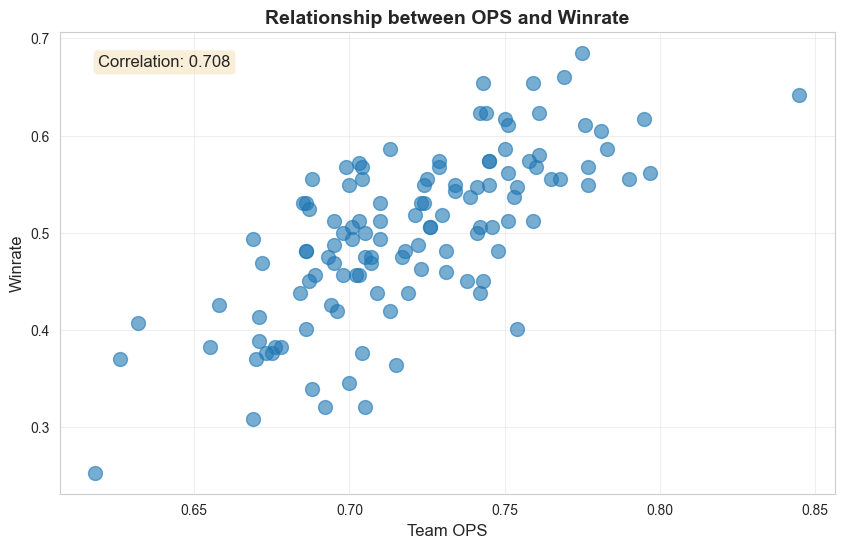

In [8]:
# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(df['ops'], df['winrate'], alpha=0.6, s=100)
plt.xlabel('Team OPS', fontsize=12)
plt.ylabel('Winrate', fontsize=12)
plt.title('Relationship between OPS and Winrate', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Correlation
corr = df['ops'].corr(df['winrate'])
plt.text(0.05, 0.95, f"Correlation: {corr:.3f}",
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

In [9]:
# Split data for training and testing
# Explanatory variables
X = df[['ops']]
# Target variable
y = df[['winrate']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 96
Test size: 24


In [12]:
# Build linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [20]:
# Regression coefficients
print(f"Intercept: {model.intercept_[0]:.3f}")
print(f"Coefficient: {model.coef_[0][0]:.3f}")
print(f"\nRegression Formula: y = {model.coef_[0][0]:.3f} * OPS + {model.intercept_[0]:.3f}")

Intercept: -0.666
Coefficient: 1.612

Regression Formula: y = 1.612 * OPS + -0.666


In [24]:
# Prediction and evaluation
y_pred = model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("=" * 50)
print("Model Evaluation")
print("=" * 50)
print(f"R^2 Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# 解釈
print(f"\n【解釈】")
print(f"- R² = {r2:.3f} → モデルは勝率の分散の{r2*100:.1f}%を説明")
print(f"- RMSE = {rmse:.4f} → 予測誤差は平均{rmse:.4f}（勝率）")
print(f"  ※ 勝率0.01の誤差は、162試合で約{0.01*162:.1f}勝の差に相当")
print(f"- MAE = {mae:.4f} → 絶対誤差の平均は{mae:.4f}（勝率）")

Model Evaluation
R^2 Score: 0.473
RMSE: 0.049
MAE: 0.039

【解釈】
- R² = 0.473 → モデルは勝率の分散の47.3%を説明
- RMSE = 0.0489 → 予測誤差は平均0.0489（勝率）
  ※ 勝率0.01の誤差は、162試合で約1.6勝の差に相当
- MAE = 0.0391 → 絶対誤差の平均は0.0391（勝率）


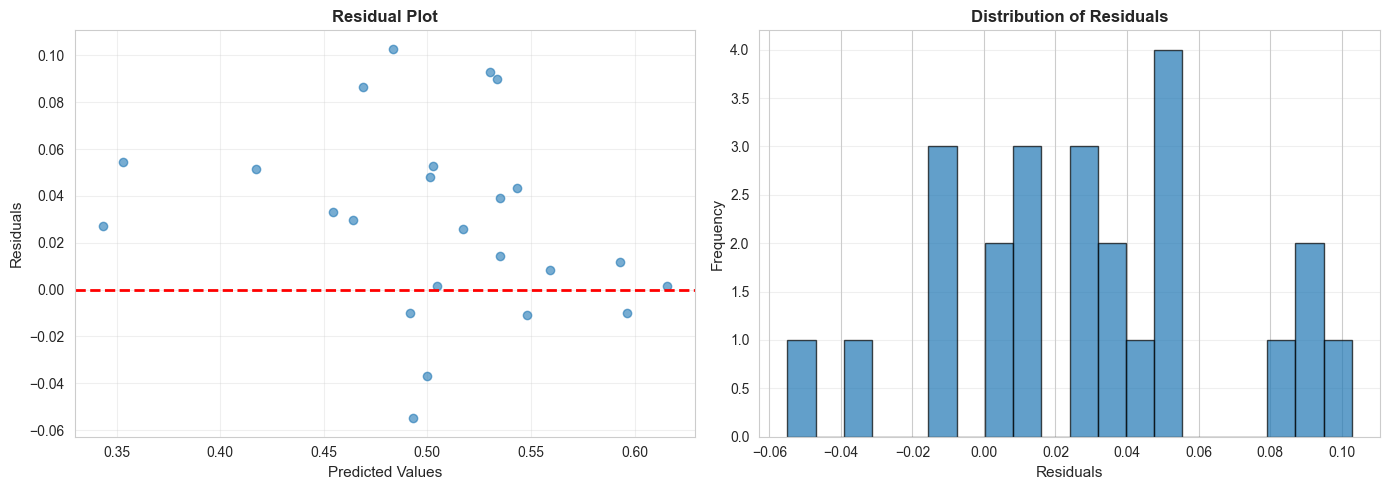


Shapiro-Wilk Test (残差の正規性):
  p-value: 0.8221
  → 残差は正規分布に従う (良好)


In [27]:
# Residual analysis
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 残差プロット
axes[0].scatter(y_pred, residuals, alpha=0.6)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values', fontsize=11)
axes[0].set_ylabel('Residuals', fontsize=11)
axes[0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# 残差の分布（ヒストグラム）
axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 正規性検定
_, p_norm = stats.shapiro(residuals)
print(f"\nShapiro-Wilk Test (残差の正規性):")
print(f"  p-value: {p_norm:.4f}")
if p_norm > 0.05:
    print(f"  → 残差は正規分布に従う (良好)")
else:
    print(f"  → 残差は正規分布に従わない可能性")

c:\Users\inthe\Desktop\Python_scripts_2025\diamond-lens\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


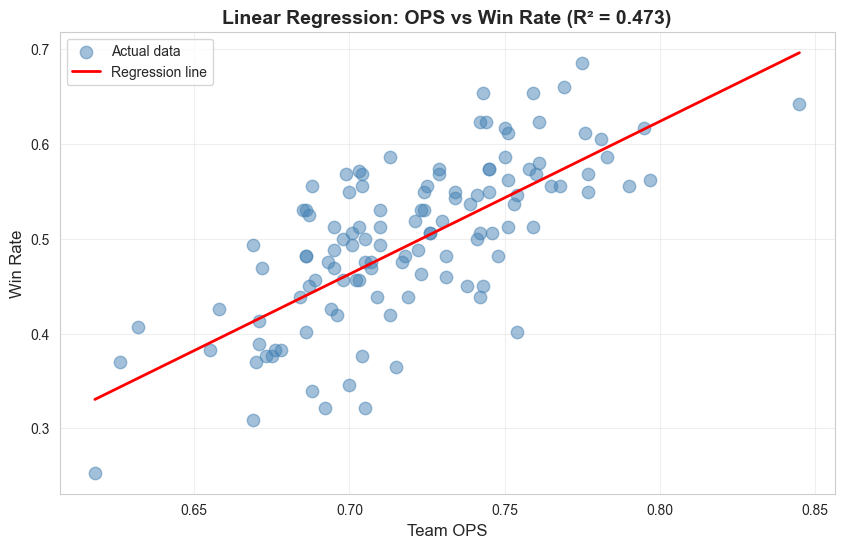


【ビジネス的解釈】
OPSが0.01向上すると、勝率が0.0161向上
シーズン162試合では、約2.61勝の増加に相当


In [35]:
# Visualization for linear regression
plt.figure(figsize=(10, 6))

# 全データの散布図
plt.scatter(df['ops'], df['winrate'],
            alpha=0.5, s=80, label='Actual data', color='steelblue')

# 回帰直線
X_range = np.linspace(df['ops'].min(), df['ops'].max(), 100).reshape(-1, 1)
y_range = model.predict(X_range)
plt.plot(X_range, y_range, color='red', linewidth=2, label='Regression line')

plt.xlabel('Team OPS', fontsize=12)
plt.ylabel('Win Rate', fontsize=12)
plt.title(f'Linear Regression: OPS vs Win Rate (R² = {r2:.3f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ビジネス的解釈
print(f"\n【ビジネス的解釈】")
print(f"OPSが0.01向上すると、勝率が{model.coef_[0][0]*0.01:.4f}向上")
print(f"シーズン162試合では、約{model.coef_[0][0]*0.01*162:.2f}勝の増加に相当")

### Regression Analysis Multivariate

In [38]:
# Multivariate
df_multivariate = client.query("SELECT * FROM `{PROJECT_ID}.{DATASET_ID}.team_ops_winrate_multivariate`").to_dataframe()

c:\Users\inthe\Desktop\Python_scripts_2025\diamond-lens\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [39]:
df_multivariate.head()

,season,team,ops,r,avg,sb,so,era,whip,hrs_allowed,winrate
0,2024,LAD,0.781,842,0.258,136,1336,3.92,1.23,198,0.604938
1,2024,ARI,0.777,886,0.263,119,1265,4.63,1.35,181,0.549383
2,2024,NYY,0.761,815,0.248,88,1326,3.76,1.24,181,0.580247
3,2024,BAL,0.751,786,0.250,98,1359,3.94,1.24,175,0.561728
4,2024,PHI,0.750,784,0.257,148,1370,3.86,1.24,181,0.586420


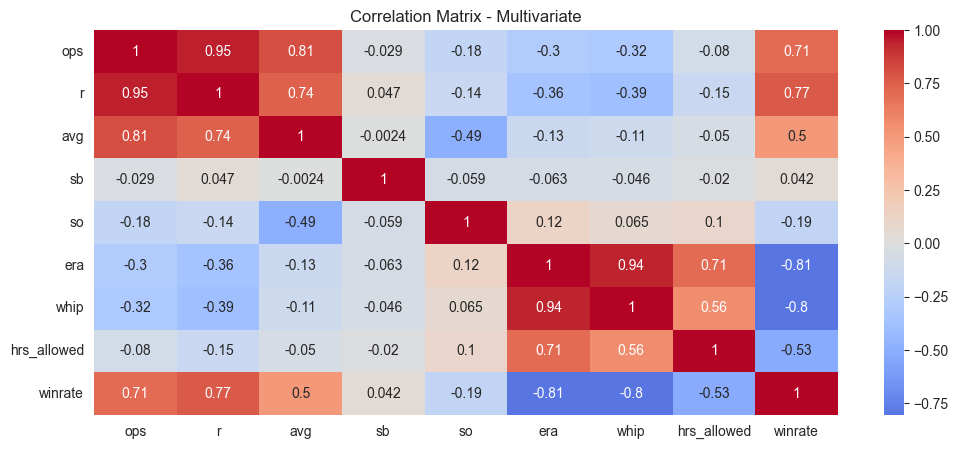

In [40]:
corr_matrix = df_multivariate[['ops', 'r', 'avg', 'sb', 'so', 'era', 'whip', 'hrs_allowed', 'winrate']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Multivariate')
plt.show()

In [41]:
# VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_multivariate[['ops', 'r', 'avg', 'sb', 'so', 'era', 'whip', 'hrs_allowed']]

vif_data = pd.DataFrame()
vif_data["features"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [51]:
def calculate_vif(df, features):
    """
    Variance Inflation Factor (VIF)を計算する関数

    VIF = 1 / (1 - R²)
    - VIF < 5: 問題なし
    - VIF 5-10: やや高い
    - VIF > 10: 多重共線性あり（削除検討）
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_list = []

    for i, target_feature in enumerate(features):
        # 対象の特徴量以外を説明変数として使用 (VIFは、「ある説明変数が、他の説明変数でどれだけ説明できるか？」を示す指標)
        other_features = [f for f in features if f != target_feature]

        X = df[other_features].values
        y = df[target_feature].values

        # 線形回帰でR²を計算
        model = LinearRegression()
        model.fit(X, y)
        r_squared = model.score(X, y)

        if r_squared < 1: # R²=1の場合を避ける
            vif = 1 / (1 - r_squared)
        else:
            vif = float('inf') # 完全に共線性がある
        
        vif_list.append(vif)
    
    vif_data["VIF"] = vif_list
    return vif_data.sort_values('VIF', ascending=False)

In [52]:
features = ['ops', 'r', 'avg', 'sb', 'so', 'era', 'whip', 'hrs_allowed']
X = df_multivariate[features].copy()

X = X.astype(float)

vif_result = calculate_vif(X, features)

print("=" * 60)
print("VIF (Variance Inflation Factor)")
print("=" * 60)
print(vif_result.to_string(index=False))
print("=" * 60)

# 判定
print("\n【判定結果】")
for idx, row in vif_result.iterrows():
    feature = row['feature']
    vif = row['VIF']
    
    if vif > 10:
        status = "❌ 多重共線性あり（削除推奨）"
    elif vif > 5:
        status = "⚠️  やや高い（注意）"
    else:
        status = "✅ 問題なし"
    
    print(f"{feature:15s} VIF={vif:8.2f}  {status}")

VIF (Variance Inflation Factor)
    feature       VIF
        ops 16.930179
        era 15.777915
          r 12.715048
       whip 11.739123
        avg  5.328534
hrs_allowed  2.681243
         so  1.732925
         sb  1.089737

【判定結果】
ops             VIF=   16.93  ❌ 多重共線性あり（削除推奨）
era             VIF=   15.78  ❌ 多重共線性あり（削除推奨）
r               VIF=   12.72  ❌ 多重共線性あり（削除推奨）
whip            VIF=   11.74  ❌ 多重共線性あり（削除推奨）
avg             VIF=    5.33  ⚠️  やや高い（注意）
hrs_allowed     VIF=    2.68  ✅ 問題なし
so              VIF=    1.73  ✅ 問題なし
sb              VIF=    1.09  ✅ 問題なし


In [53]:
features = ['ops', 'avg', 'sb', 'so', 'era', 'hrs_allowed']
X = df_multivariate[features].copy()

X = X.astype(float)

vif_result = calculate_vif(X, features)

print("=" * 60)
print("VIF (Variance Inflation Factor)")
print("=" * 60)
print(vif_result.to_string(index=False))
print("=" * 60)

# 判定
print("\n【判定結果】")
for idx, row in vif_result.iterrows():
    feature = row['feature']
    vif = row['VIF']
    
    if vif > 10:
        status = "❌ 多重共線性あり（削除推奨）"
    elif vif > 5:
        status = "⚠️  やや高い（注意）"
    else:
        status = "✅ 問題なし"
    
    print(f"{feature:15s} VIF={vif:8.2f}  {status}")

VIF (Variance Inflation Factor)
    feature      VIF
        avg 5.229489
        ops 4.583286
        era 2.548244
hrs_allowed 2.147570
         so 1.727284
         sb 1.013451

【判定結果】
avg             VIF=    5.23  ⚠️  やや高い（注意）
ops             VIF=    4.58  ✅ 問題なし
era             VIF=    2.55  ✅ 問題なし
hrs_allowed     VIF=    2.15  ✅ 問題なし
so              VIF=    1.73  ✅ 問題なし
sb              VIF=    1.01  ✅ 問題なし


In [60]:
from sklearn.preprocessing import StandardScaler

features_final = ['ops', 'era', 'hrs_allowed']
X_final = df_multivariate[features_final]
y = df_multivariate['winrate']

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Train model with finalized features
model_final = LinearRegression()
model_final.fit(X_train, y_train)

# Evaluate model
y_pred = model_final.predict(X_test)
r2_final = r2_score(y_test, y_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))

print("=" * 60)
print("【最終モデル: OPS + ERA + hrs_allowed】")
print("=" * 60)
print(f"R²:   {r2_final:.3f}")
print(f"RMSE: {rmse_final:.4f}\n")
print("係数:")
for feature, coef in zip(features_final, model_final.coef_):
    print(f"  {feature:15s} {coef:8.4f}")
print("=" * 60)


# Standardize features
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X_final)
X_train_s, X_test_s, _, _ = train_test_split(
    X_scaled_final, y, test_size=0.2, random_state=42
)
model_scaled_final = LinearRegression()
model_scaled_final.fit(X_train_s, y_train)

print("\n標準化係数:")
for feature, coef in zip(features_final, model_scaled_final.coef_):
    print(f"  {feature:15s} {coef:8.4f}")

【最終モデル: OPS + ERA + hrs_allowed】
R²:   0.858
RMSE: 0.0254

係数:
  ops               1.1617
  era              -0.0939
  hrs_allowed      -0.0001

標準化係数:
  ops               0.0433
  era              -0.0516
  hrs_allowed      -0.0030
